Pick images with flowers clearly located in a certain region.
We compute the mean of mask values at many 16\*16 patches, and pick those with standard deviation larger than a threshold.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import sys
sys.path.append('..')
from gan_utils import *
tqdm.pandas()

In [2]:
df = pd.read_csv('mask_pred_dict.csv', header=None, names=['file','mean_mask'])
df['synset'] = df['file'].apply(lambda x: x.split('_')[0])
synset = df.groupby('synset').agg({'file':'count','mean_mask':'mean'}).sort_values('mean_mask', ascending=False)
df['synset_count'] = df['synset'].map(synset['file'])
df.head()

,file,mean_mask,synset,synset_count
0,n11721337_10018_1.jpg,0.408157,n11721337,1356
1,n11721337_10018_2.jpg,0.104775,n11721337,1356
2,n11721337_10066_1.jpg,0.628754,n11721337,1356
3,n11721337_10066_2.jpg,0.654473,n11721337,1356
4,n11721337_10088_1.jpg,0.081692,n11721337,1356


In [3]:
def mask_stats(mask_file, f=16, s=4):
    mask = io.imread(mask_file, is_gray=True)
    H,W = mask.shape
    grid = np.zeros([int((H-f)/s+1), int((W-f)/s+1)])
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            grid[i,j] = mask[i*s:i*s+f, j*s:j*s+f].mean()
    return grid.std(), grid.max()-grid.min()


df['mask_stats'] = df['file'].progress_apply(lambda x: mask_stats('mask_pred64/'+x))
df['std_mask'] = df['mask_stats'].apply(lambda x: x[0])
df['minmax_mask'] = df['mask_stats'].apply(lambda x: x[1])
df.head()

100%|██████████| 70638/70638 [21:01<00:00, 56.02it/s] 


,file,mean_mask,synset,synset_count,mask_stats,std_mask,minmax_mask
0,n11721337_10018_1.jpg,0.408157,n11721337,1356,"(53.82545342878944, 182.9609375)",53.825453,182.960938
1,n11721337_10018_2.jpg,0.104775,n11721337,1356,"(12.35967658727604, 58.0)",12.359677,58.000000
2,n11721337_10066_1.jpg,0.628754,n11721337,1356,"(52.68175480723883, 205.3203125)",52.681755,205.320312
3,n11721337_10066_2.jpg,0.654473,n11721337,1356,"(49.222465769073274, 209.40625)",49.222466,209.406250
4,n11721337_10088_1.jpg,0.081692,n11721337,1356,"(14.836010908943878, 63.71484375)",14.836011,63.714844


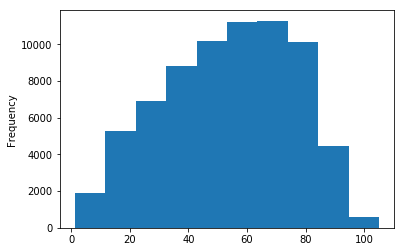

In [4]:
df['std_mask'].plot.hist()

In [5]:
mask_sizes = [64]
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

0it [00:00, ?it/s]/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
64it [00:02, 34.10it/s]


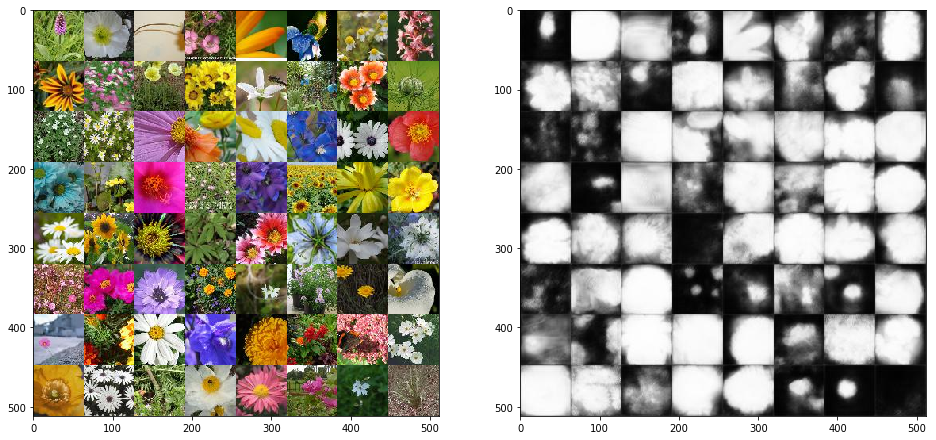

In [7]:
# images we don't use: mask with small variation at different location
# large flowers / small scattering flowers
files = df['file'].loc[df['std_mask']<60].sample(64).values
image_paths = [os.path.join("flower64", file) for file in files]
mask_paths = [os.path.join("mask_pred64", file) for file in files]
my_transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
realflower = flower_mask_dataset(image_paths, mask_paths,
                            transform = my_transform,
                            mask_sizes = mask_sizes,
                            mask_transform = my_transform,
                            in_memory = True) 
realdata = realflower
dataloader = DataLoader(realdata, batch_size=128, shuffle=True, num_workers=1)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(vutils.make_grid(real_batch[1][-1].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.show()

64it [00:01, 39.98it/s]


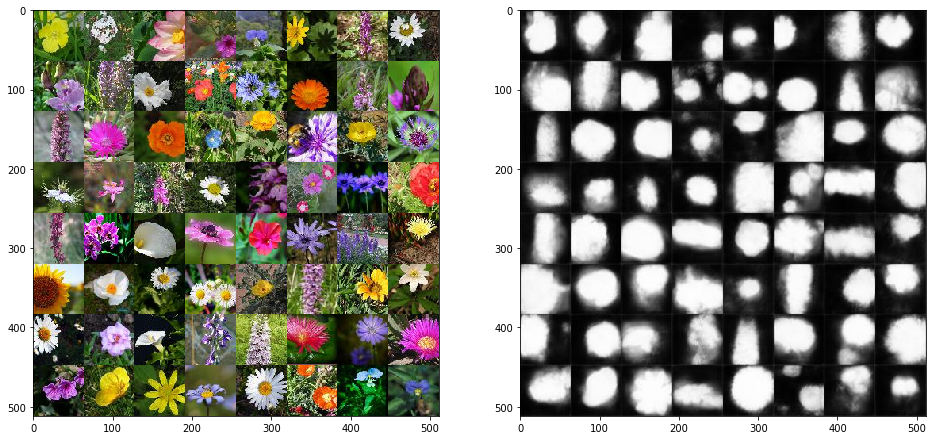

In [8]:
# check what we are left with: flowers clearly located at a certain region
sampled_df = df.loc[df['mean_mask']<0.8]
sampled_df = sampled_df.loc[df['std_mask']>60]
sampled_df = sampled_df.loc[df['minmax_mask']>220]

files = sampled_df['file'].sample(64).values
image_paths = [os.path.join("flower64", file) for file in files]
mask_paths = [os.path.join("mask_pred64", file) for file in files]
my_transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
realflower = flower_mask_dataset(image_paths, mask_paths,
                            transform = my_transform,
                            mask_sizes = mask_sizes,
                            mask_transform = my_transform,
                            in_memory = True)
realdata = realflower
dataloader = DataLoader(realdata, batch_size=128, shuffle=True, num_workers=1)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(vutils.make_grid(real_batch[1][-1].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.show()

In [9]:
print(sampled_df.shape)
sampled_df.to_csv('mask_pred_dict_sampled.csv', index=False)

(27030, 7)


In [12]:
plt.savefig("left_images.jpg")

<Figure size 432x288 with 0 Axes>